## Chassisml Example Notebooks
Welcome to the examples section for [Chassis.ml](https://chassis.ml), which contains notebooks that leverage Chassisml to auto-containerize models built using the most common machine learning frameworks. 

**NOTE:** Chassisml provides two key functionalities: 
1. Create a Docker container from your model code and push that container image to a Docker registry. This is the default behavior.
2. Should you pass valid Modzy credentials as optional parameters, Chassisml will take the container and upload it directly to the Modzy environment you specify. You will notice most of these notebooks deploy the model to one of the Modzy internal development environments.   

Can't find the framework you are looking for? Fork this repository and open a PR, we're always interested in growing this example bank! 

In [16]:
import cv2
import pickle
import tempfile
import chassisml
import numpy as np
import getpass
from shutil import rmtree
import json
import onnx
from onnx import backend
from onnx import numpy_helper
import onnxruntime as ort
import matplotlib.pyplot as plt

## Enter credentials
Dockerhub creds and Modzy API Key

In [2]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')
modzy_api_key = getpass.getpass('modzy api key')

docker hub username········
docker hub password········
modzy api key········


## Load ONNX Model and Test Locally
This model was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models/tree/master/vision/classification/mobilenet), which contains several pre-trained models saved in the ONNX open standard format.

In [3]:
# load model
model = onnx.load("models/mobilenetv2-7.onnx")

# check onnx file is valid model
onnx.checker.check_model(model)

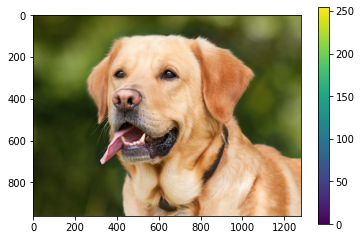

In [4]:
# format sample data and reshape
img = cv2.cvtColor(cv2.imread('data/dog.jpg'), cv2.COLOR_BGR2RGB)
img_show = cv2.resize(img, (224,224))

sample_img = np.reshape(img_show, (1,3,224,224)).astype(np.float32)

# load imagenet labels
labels = pickle.load(open('./data/imagenet_labels.pkl','rb'))

# visualize image
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
# create onnx runtime inference session and print top prediction
session = ort.InferenceSession("models/mobilenetv2-7.onnx")
results = session.run(None, {"input": sample_img})
print("Top Prediction: {}".format(labels[results[0].argmax()]))

Top Prediction: sunglass


## Prepare context dict
Initialize anything here that should persist across inference runs

In [17]:
# This will be passed to Chassis:
context = {
    "model": model,
    "labels": labels
}

## Write process function

* Must take bytes and context dict as input
* Preprocess bytes, run inference, postprocess model output, return results

In [18]:
def process(input_bytes,context):
    # save model to filepath for inference
    tmp_dir = tempfile.mkdtemp()
    import onnx
    onnx.save(context["model"], "{}/model.onnx".format(tmp_dir))
    
    # preprocess data
    decoded = cv2.cvtColor(cv2.imdecode(np.frombuffer(input_bytes, np.uint8), -1), cv2.COLOR_BGR2RGB)
    img = cv2.resize(decoded, (224,224))
    img = np.reshape(img, (1,3,224,224)).astype(np.float32)
    
    # run inference
    session = ort.InferenceSession("{}/model.onnx".format(tmp_dir))
    results = session.run(None, {"input": img})
    
    # postprocess
    inference_result = context["labels"][results[0].argmax()]
    
    # format results
    structured_result = {
        "data": {
            "result": {"classPredictions": [{"class": str(inference_result)}]}
        }
    }
    
    # remove temp directory
    rmtree(tmp_dir)
    return structured_result

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [19]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `context` dict containing all variables which should be loaded once and persist across inferences
* Requires `process_fn` defined above

In [ ]:
# create Chassis model
chassis_model = chassis_client.create_model(context=context,process_fn=process)

# test Chassis model locally (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/dog.jpg'
results = chassis_model.test(sample_filepath)
print(results)

In [21]:
# test environment and model within Chassis service, must pass filepath here:

# dry run before build
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

Starting test job... Ok!
{'model_output': 'Single input prediction:\n\nb\'{"data":{"result":{"classPredictions":[{"class":"sunglass"}]}}}\'\n'}


## Publish model to Modzy
Need to provide model name, model version, Dockerhub credentials, and required Modzy info

In [22]:
response = chassis_model.publish(
    model_name="ONNX MobileNet Image Classification",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
    modzy_sample_input_path=sample_filepath,
    modzy_api_key=modzy_api_key
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

Starting build job... Ok!


In [23]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

New model URL: https://integration.modzy.engineering/models/ehojcqknx4/0.0.1


## Run sample job using Modzy SDK
Submit inference job to our newly-deploy model running on Modzy

In [24]:
from modzy import ApiClient

client = ApiClient(base_url='https://integration.modzy.engineering/api', api_key=modzy_api_key)

input_name = final_status['result']['inputs'][0]['name']
model_id = final_status['result'].get("model").get("modelId")
model_version = final_status['result'].get("version")

inference_job = client.jobs.submit_file(model_id, model_version, {input_name: sample_filepath})
inference_job_result = client.results.block_until_complete(inference_job, timeout=None)
inference_job_results_json = inference_job_result.get_first_outputs()['results.json']
print(inference_job_results_json)

ApiObject({
  "data": {
    "result": {
      "classPredictions": [
        {
          "class": "sunglass"
        }
      ]
    }
  }
})
